In [3]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
from gym.wrappers.record_video import RecordVideo
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory():
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
    
    # for interacting with environment
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    # for ppo update
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        # action_logprobs indirectly represents the policy $\pi_{\theta}(s,a)$
        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO():
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory, timestep):   
        # Monte Carlo estimate of state rewards (can be replaced by General Advantage Estimators)
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # linear rate annealing added -- 
            frac = (timestep - 1.0) / 1000000
            new_lr = self.lr * (1.0 - frac)
            new_lr = max(new_lr, 0.0)
            self.optimizer.param_groups[0]["lr"] = new_lr

 
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss (no gradient in advantages)
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            # MseLoss is for the update of critic, dist_entropy denotes an entropy bonus
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)  # Gradient clipping
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        
def main():
    ############## Hyperparameters ##############
    env_name = "LunarLander-v2"
    # creating environment
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env=env, video_folder="./videos", name_prefix="test-video")
    state_dim = env.observation_space.shape[0]
    action_dim = 4
    render = False
    solved_reward = 230         # stop training if avg_reward > solved_reward
    log_interval = 20           # print avg reward in the interval
    max_episodes = 50000        # max training episodes
    max_timesteps = 500         # max timesteps in one episode
    n_latent_var = 256           # number of variables in hidden layer
    update_timestep = 2000      # update policy every n timesteps
    lr = 0.003
    betas = (0.9, 0.999)
    gamma = 0.99                # discount factor
    K_epochs = 4                # update policy for K epochs
    eps_clip = 0.2              # clip parameter for PPO
    random_seed = None
    #############################################
    
    if random_seed:
        torch.manual_seed(random_seed)
        env.seed(random_seed)
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
    print('learning rate:',lr, 'Adam betas:', betas)
    
    # logging variables
    running_reward = 0
    avg_length = 0
    timestep = 0
    rew_for_plots = []

    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()[0]
        
        for t in range(max_timesteps):
            timestep += 1
            
            # Running policy_old:
            # also append state, action, action_logprobs to the memory
            with torch.no_grad():
                action = ppo.policy_old.act(state, memory)
            state, reward, done, truncated, _ = env.step(action)
            
            # Saving reward and is_terminal:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            # update if its time
            if timestep % update_timestep == 0:
                ppo.update(memory, timestep)
                memory.clear_memory()
                timestep = 0
            
            running_reward += reward
            # if render:
            #     env.render()
            if done or truncated:
                break
                
        avg_length += t
        rew_for_plots.append(running_reward)



        # stop training if avg_reward > solved_reward
        if running_reward > (log_interval*solved_reward):
            print("########## Solved! ##########")
            torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(env_name))
            plt.plot(rew_for_plots)
            plt.title('Average Episodic Return vs. Cumulative Timesteps')
            plt.xlabel('Cumulative Timesteps')
            plt.ylabel('Average Episodic Return')
            plt.grid(True)
            plt.show()
            break
            
        # logging
        if i_episode % log_interval == 0:
            avg_length = int(avg_length/log_interval)
            running_reward = int((running_reward/log_interval))
            
            print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))
            running_reward = 0
            avg_length = 0
    
    

        


c:\Users\lijun\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\lijun\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


learning rate: 0.003 Adam betas: (0.9, 0.999)
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4
Episode 20 	 avg length: 90 	 reward: -135
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4
Episode 40 	 avg length: 100 	 reward: -247
Episode 60 	 avg length: 90 	 reward: -150
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4
Episode 80 	 avg length: 95 	 reward: -129
Episode 100 	 avg length: 94 	 reward: -113
Episode 120 	 avg length: 99 	 reward: -93
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4
Episode 140 	 avg length: 115 	 reward: -90
Episode 160 	 avg length: 103 	 reward: -80
Episode 180 	 avg length: 104 	 reward: -59
Episode 200 	 avg length: 137 	 reward: -41
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4
Episode 220 	 avg length: 152 	 reward: -20
Episode 240 	 avg length: 138 	 reward: -42
Episode 260 	 avg length: 210 	 reward: -40
Episode 280 	 avg length: 262 	 reward: -39
Episode 300 	 avg length: 257 	 reward: -105
Episode 320 	 avg length: 279 	 reward: -96
Episode 340 	 avg length: 250 	 reward: -30
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4
Episode 360 	 avg length: 296 	 reward: 4
Episode 380 	 avg length: 313 	 reward: 99
Episode 400 	 avg length: 237 	 reward: 30
Episode 420 	 avg length: 345 	 reward: 64
Episode 440 	 avg length: 295 	 reward: 32
Episode 460 	 avg length: 405 	 reward: 73
Episode 480 	 avg length: 429 	 reward: 30
Episode 500 	 avg length: 394 	 reward: 55
Episode 520 	 avg length: 440 	 reward: 90
Episode 540 	 avg length: 288 	 reward: 101
Episode 560 	 avg length: 417 	 reward: 131
Episode 580 	 avg length: 332 	 reward: 82
Episode 600 	 avg length: 392 	 reward: 119
Episode 620 	 avg length: 467 	 reward: 63
Episode 640 	 avg length: 431 	 reward: 117
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-512.mp4.
Mov

Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-512.mp4
Episode 660 	 avg length: 425 	 reward: 137
Episode 680 	 avg length: 398 	 reward: 131
Episode 700 	 avg length: 363 	 reward: 98
Episode 720 	 avg length: 384 	 reward: 136
Episode 740 	 avg length: 412 	 reward: 105
Episode 760 	 avg length: 405 	 reward: 99
Episode 780 	 avg length: 439 	 reward: 79
Episode 800 	 avg length: 448 	 reward: 98
Episode 820 	 avg length: 433 	 reward: 121
Episode 840 	 avg length: 466 	 reward: 96
Episode 860 	 avg length: 403 	 reward: 114
Episode 880 	 avg length: 427 	 reward: 135
Episode 900 	 avg length: 315 	 reward: 112
Episode 920 	 avg length: 394 	 reward: 129
Episode 940 	 avg length: 409 	 reward: 112
Episode 960 	 avg length: 449 	 reward: 156
Episode 980 	 avg length: 428 	 reward: 143
Episode 1000 	 avg length: 442 	 reward: 138
Episode 1020 	 avg length: 437 

Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-729.mp4
Episode 1260 	 avg length: 335 	 reward: 68
Episode 1280 	 avg length: 402 	 reward: 103
Episode 1300 	 avg length: 325 	 reward: 92
Episode 1320 	 avg length: 290 	 reward: 89
Episode 1340 	 avg length: 223 	 reward: 63
Episode 1360 	 avg length: 358 	 reward: 99
Episode 1380 	 avg length: 244 	 reward: 71
Episode 1400 	 avg length: 297 	 reward: 94
Episode 1420 	 avg length: 422 	 reward: 122
Episode 1440 	 avg length: 408 	 reward: 126
Episode 1460 	 avg length: 468 	 reward: 154
Episode 1480 	 avg length: 444 	 reward: 131
Episode 1500 	 avg length: 366 	 reward: 111
Episode 1520 	 avg length: 348 	 reward: 103
Episode 1540 	 avg length: 418 	 reward: 116
Episode 1560 	 avg length: 421 	 reward: 128
Episode 1580 	 avg length: 375 	 reward: 111
Episode 1600 	 avg length: 379 	 reward: 112
Episode 1620 	 a

Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1000.mp4
Episode 2000 	 avg length: 153 	 reward: 47
Episode 2020 	 avg length: 129 	 reward: 41
Episode 2040 	 avg length: 154 	 reward: 63
Episode 2060 	 avg length: 161 	 reward: 42
Episode 2080 	 avg length: 161 	 reward: 53
Episode 2100 	 avg length: 329 	 reward: 108
Episode 2120 	 avg length: 327 	 reward: 104
Episode 2140 	 avg length: 328 	 reward: 106
Episode 2160 	 avg length: 402 	 reward: 132
Episode 2180 	 avg length: 461 	 reward: 149
Episode 2200 	 avg length: 446 	 reward: 146
Episode 2220 	 avg length: 415 	 reward: 87
Episode 2240 	 avg length: 376 	 reward: 109
Episode 2260 	 avg length: 355 	 reward: 81
Episode 2280 	 avg length: 387 	 reward: 10
Episode 2300 	 avg length: 331 	 reward: -60
Episode 2320 	 avg length: 395 	 reward: 53
Episode 2340 	 avg length: 357 	 reward: 53
Episode 2360 	 avg

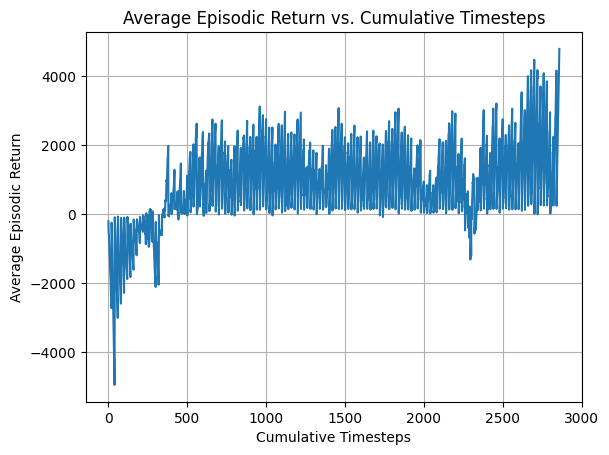

In [4]:
if __name__ == '__main__':
    main()

In [ ]:
    ###########################################################################
    def running_mean(x):
        N=50
        kernel = np.ones(N)
        conv_len = x.shape[0]-N
        y = np.zeros(conv_len)
        for i in range(conv_len):
            y[i] = kernel @ x[i:i+N]
            y[i] /= N
        return y
    episode_rewards_history_reinforce = np.array(episode_rewards_history)
    avg_score_reinforce = running_mean(episode_rewards_history_reinforce)
    episode_rewards_history_rand = np.array(episode_rewards_history_rand)
    avg_score_rand = running_mean(episode_rewards_history_rand)

    plt.figure(figsize=(15,7))
    plt.ylabel("Rewards",fontsize=12)
    plt.xlabel("Episodes",fontsize=12)
    plt.plot(episode_rewards_history_reinforce, color='gray' , linewidth=1)
    plt.plot(avg_score_reinforce, color='blue', linewidth=3,label = 'Running Average Score of REINFORCE Policy')
    plt.plot(avg_score_rand, color='orange', linewidth=3,label = 'Running Average Score of Random Policy')
    plt.axhline(y=200, color='r', linestyle='-',label = 'Solved')
    plt.scatter(np.arange(episode_rewards_history_reinforce.shape[0]),episode_rewards_history_reinforce, 
                color='green' , linewidth=0.3, label='Episode Rewards')
    plt.legend()

    plt.title('Rewards by Episode For Reinforce in Lunar Lander')
    ##################################################################################

